# Predicting hourly energy consumption
Dayton hourly power consumption data acquired from https://www.kaggle.com/robikscube/hourly-energy-consumption?select=DAYTON_hourly.csv  
Weather data acquired from https://www.ncdc.noaa.gov/

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
dayton = pd.read_csv('./DAYTON_hourly.csv', parse_dates=['Datetime'], date_parser=mydateparser)

In [99]:
dayton.shape

(121275, 3)

In [49]:
dayton.sample(10)

,Datetime,DAYTON_MW,date
117717,2018-05-29 18:00:00,3044.0,2018-05-29
40130,2009-09-03 13:00:00,2214.0,2009-09-03
15121,2006-07-11 06:00:00,1966.0,2006-07-11
94555,2015-06-18 15:00:00,2956.0,2015-06-18
118706,2018-04-18 23:00:00,1837.0,2018-04-18
42084,2009-06-14 23:00:00,1873.0,2009-06-14
59224,2011-06-29 08:00:00,1822.0,2011-06-29
49993,2010-07-19 15:00:00,3106.0,2010-07-19
30649,2008-10-02 10:00:00,2088.0,2008-10-02
65828,2012-09-27 14:00:00,2026.0,2012-09-27


In [4]:
dayton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [81]:
dayton.describe()

,DAYTON_MW
count,121275.000000
mean,2037.851140
std,393.403153
min,982.000000
25%,1749.000000
50%,2009.000000
75%,2279.000000
max,3746.000000


In [5]:
weather = pd.read_csv('./dayton-weather.csv', parse_dates=['DATE'])

In [7]:
# getting the average readings per day from all weather stations
weather_agg = weather.groupby('DATE').mean()

In [8]:
weather_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2004-01-01 to 2018-12-31
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TAVG    2679 non-null   float64
 1   TMAX    5479 non-null   float64
 2   TMIN    5479 non-null   float64
 3   WT01    2758 non-null   float64
 4   WT02    333 non-null    float64
 5   WT03    812 non-null    float64
 6   WT04    71 non-null     float64
 7   WT05    17 non-null     float64
 8   WT06    34 non-null     float64
 9   WT08    1480 non-null   float64
 10  WT09    25 non-null     float64
 11  WT11    48 non-null     float64
 12  WT13    1593 non-null   float64
 13  WT14    132 non-null    float64
 14  WT15    12 non-null     float64
 15  WT16    1360 non-null   float64
 16  WT17    36 non-null     float64
 17  WT18    494 non-null    float64
 18  WT19    21 non-null     float64
 19  WT21    7 non-null      float64
 20  WT22    38 non-null     float64
dtypes: float64(21)
memo

In [9]:
dayton['date'] = dayton['Datetime'].dt.date.astype('datetime64')

In [10]:
# creating a dataset with the min and max daily temperatures and the hourly consumption
dataset = dayton.merge(weather_agg, right_index=True, left_on='date', how='left')[['Datetime','TMIN','TMAX','DAYTON_MW']]
dataset.sample(10)

,Datetime,TMIN,TMAX,DAYTON_MW
17987,2006-03-14 17:00:00,31.000000,53.000000,2255.0
76532,2013-07-09 16:00:00,72.666667,88.000000,3092.0
57971,2011-08-20 03:00:00,64.333333,87.666667,1652.0
118174,2018-05-10 19:00:00,60.250000,83.000000,2222.0
81863,2014-11-29 20:00:00,28.333333,49.666667,1848.0
98325,2015-01-12 18:00:00,24.333333,35.333333,2517.0
52375,2010-04-11 21:00:00,40.666667,70.000000,1697.0
4944,2005-09-08 03:00:00,59.333333,84.000000,1718.0
81078,2014-12-31 03:00:00,12.333333,28.666667,1866.0
97389,2015-02-20 18:00:00,-7.000000,18.000000,2586.0


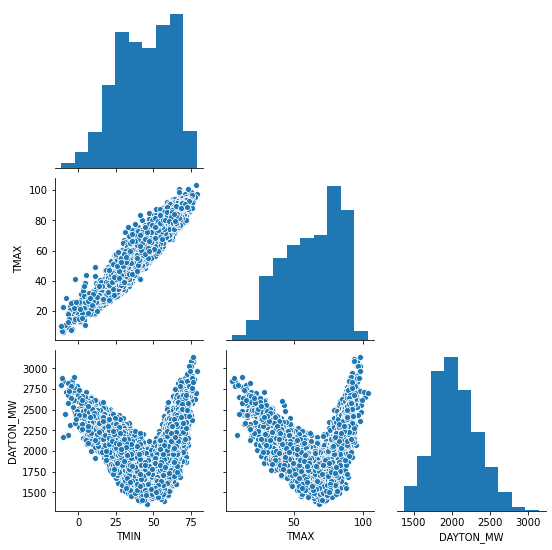

In [93]:
import seaborn as sns
plot_data = dataset.groupby(dataset['Datetime'].dt.date).mean()[['TMIN','TMAX','DAYTON_MW']]
sns.pairplot(plot_data, corner=True);

In [12]:
!pip install holidays
import holidays
us_holidays = holidays.UnitedStates()

In [13]:
# adding business day indication based on weekdays and US holidays
dataset['business_day'] = dataset['Datetime'].dt.date.apply(lambda x: np.is_busday(x) and x not in us_holidays)

In [14]:
dataset['hour'] = dataset['Datetime'].dt.hour

In [88]:
dataset.corr()

,TMIN,TMAX,DAYTON_MW,business_day,hour
TMIN,1.000000,0.954602,-0.013910,0.025636,-0.000150
TMAX,0.954602,1.000000,-0.043023,0.021968,-0.000126
DAYTON_MW,-0.013910,-0.043023,1.000000,0.347722,0.443914
business_day,0.025636,0.021968,0.347722,1.000000,-0.000301
hour,-0.000150,-0.000126,0.443914,-0.000301,1.000000


In [27]:
from sklearn.model_selection import train_test_split, cross_val_score

numeric_features = ['TMIN','TMAX']
categorical_features = ['business_day','hour']

X = dataset[numeric_features + categorical_features]
y = dataset.DAYTON_MW
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [95]:
# Trying straight-forward linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression() 
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.3256343079744213

In [98]:
# adding some preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

plr = Pipeline([('preprocessor', preprocessor), ('model', LinearRegression())])

In [97]:
%%time
plr.fit(X_train, y_train)
plr.score(X_test, y_test)

CPU times: user 499 ms, sys: 72.8 ms, total: 572 ms
Wall time: 317 ms


0.768010459871846

In [73]:
scores = cross_val_score(plr, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

192.53561483922354

In [22]:
# %%time
# scores = cross_val_score(plcv, X, y, cv=5, scoring='neg_mean_squared_error')
# np.mean(np.sqrt(-scores))

## Parameter tuning

In [75]:
# Parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = {
    'preprocessor__num__poly__degree': range(2,10),
    'model__alpha': [1e-3, 1e-2, 1e-1, 1, 10]}

pipe = Pipeline([('preprocessor', preprocessor), ('model', Ridge())])

grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [76]:
%%time
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

CPU times: user 2min 8s, sys: 12.8 s, total: 2min 21s
Wall time: 41.1 s


0.7741437717619808

In [79]:
scores = cross_val_score(grid_search, X, y, cv=5, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

191.5039231038041

In [80]:
grid_search.best_params_

{'model__alpha': 0.001, 'preprocessor__num__poly__degree': 9}